# Implimenting the GPT model


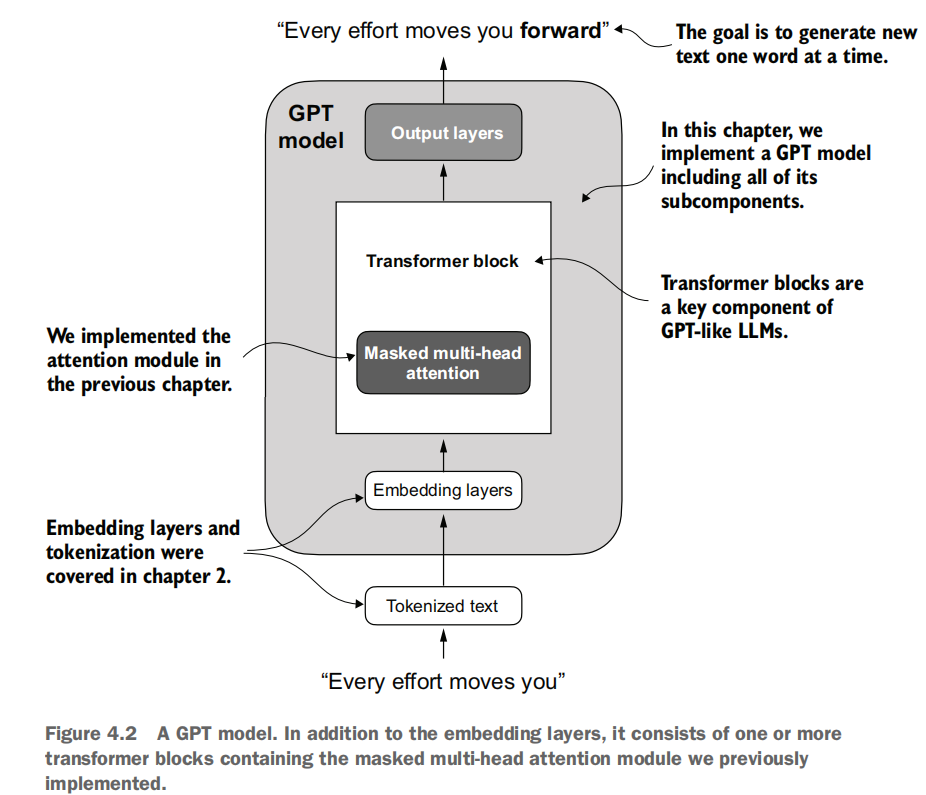

In [3]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

## DummyGPT model

The numbered boxes in figure 4.3 illustrate the order in which we tackle the individual concepts required to code the final GPT architecture.\
We will start with step 1,a placeholder GPT backbone we will call DummyGPTModel.


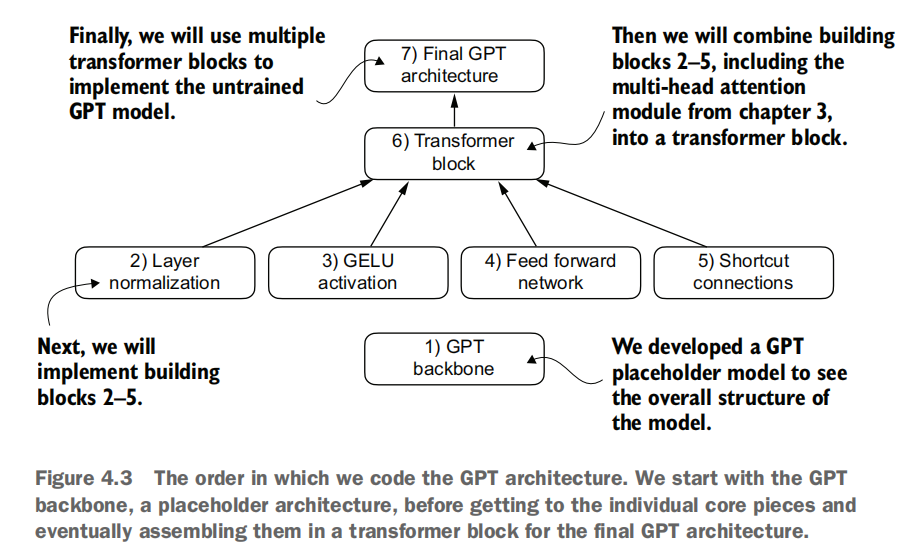

In [4]:
import torch
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential( 
        *[DummyTransformerBlock(cfg) 
        for _ in range(cfg["n_layers"])] 
        ) 
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) 
        self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
class DummyTransformerBlock(nn.Module): 
    def __init__(self, cfg):
        super().__init__()
    def forward(self, x): 
        return x
class DummyLayerNorm(nn.Module): 
    def __init__(self, normalized_shape, eps=1e-5): 
        super().__init__()
    def forward(self, x):
        return x

### Next we will prepare the data input and intialize a new GPT model to illustrate its usage

In [5]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


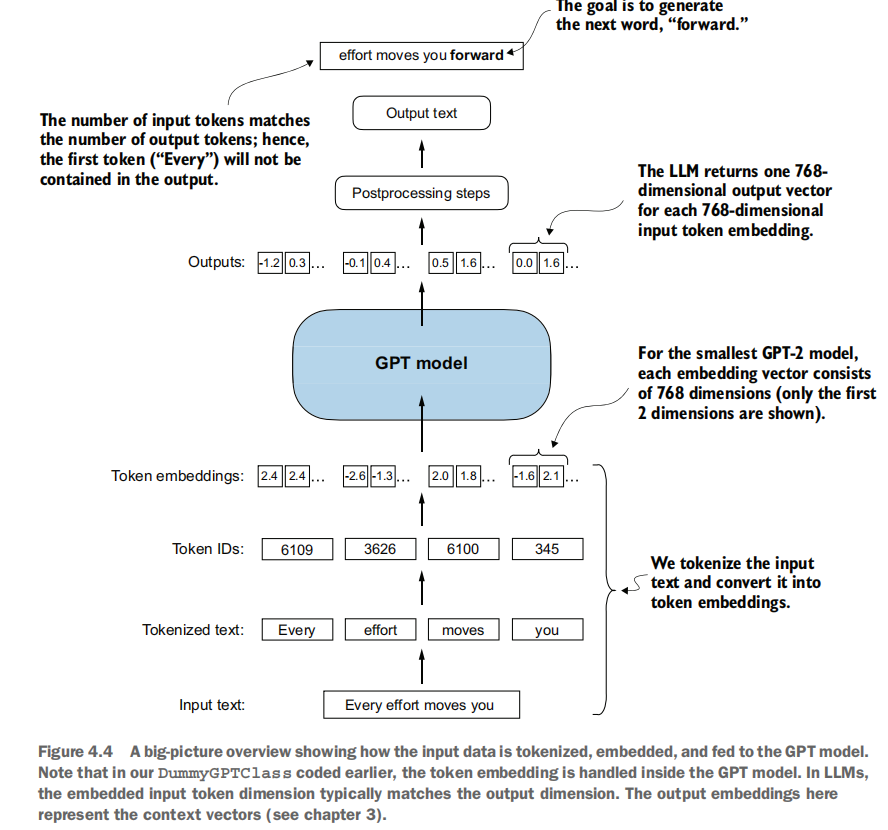

In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### This output has 2 row as two text were given, each with 4 tokens and each token of 50257 dim. each of which corressponds to the a token-id which we will use to find the token-id in the post-processing.


## Normalizing activations with layer normalization

In GPT-2 and modern transformer architectures,\
layer normalization is typically applied before and after the multi-head\
attention module, and, as we have seen with the DummyLayerNorm placeholder, before the final output layer.

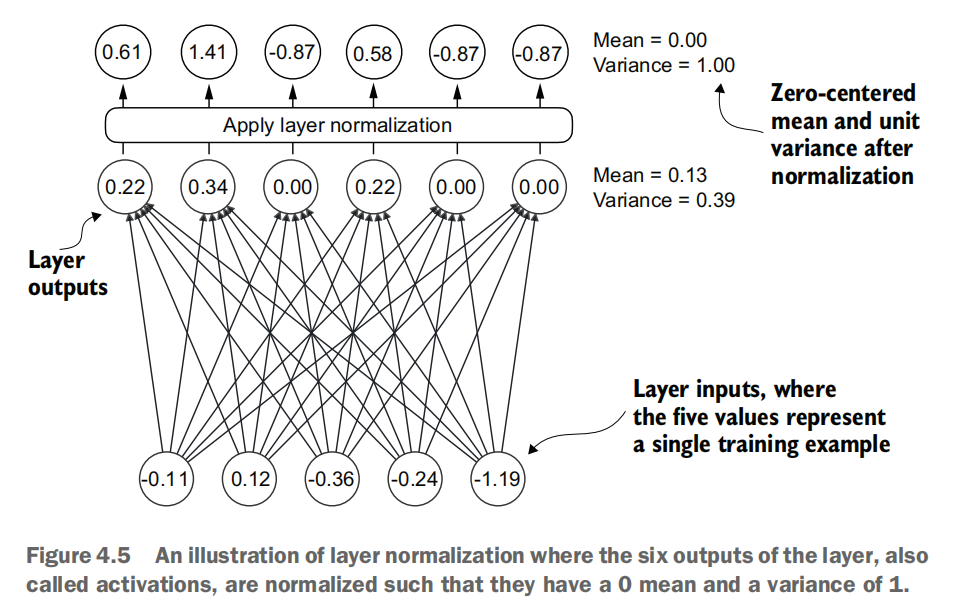

In [7]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) 
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


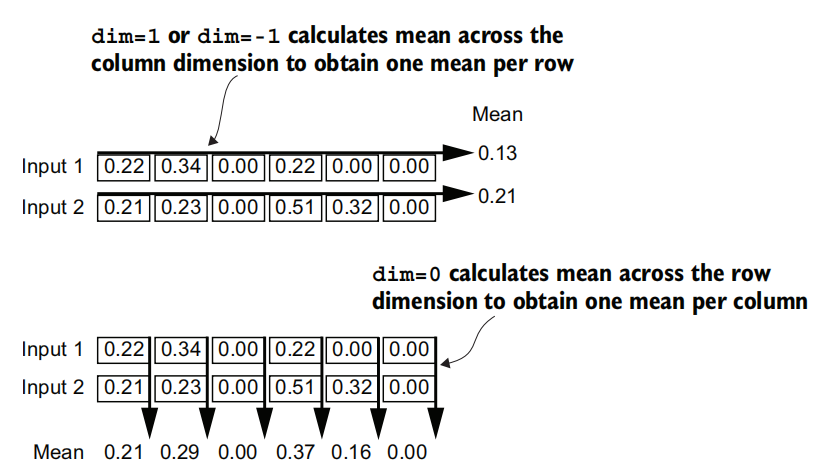

In [9]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Layer Normalization

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Implementing a feed forward network with GELU activations

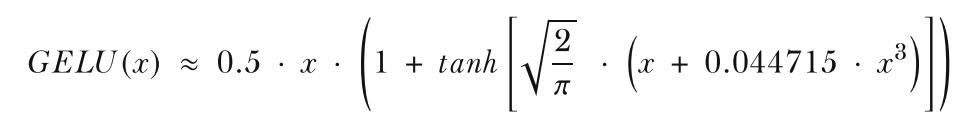

In [13]:
class GELU(nn.Module):
 def __init__(self):
    super().__init__()
 def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
    torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
    (x + 0.044715 * torch.pow(x, 3))
    ))

In [14]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) 
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

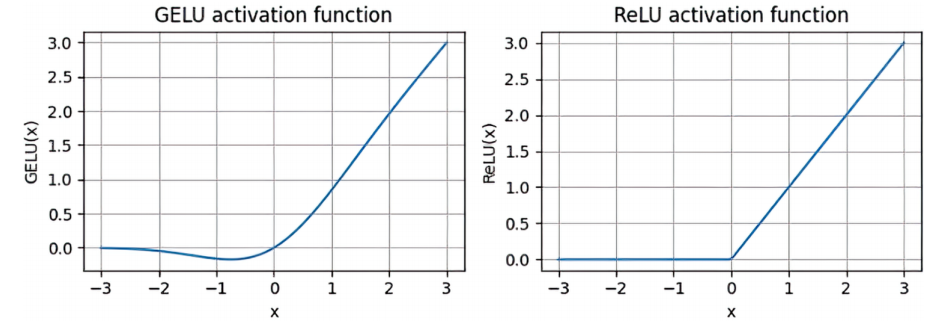

## The FeedForward layer

In [15]:
class FeedForward(nn.Module):
 def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
    GELU(),
    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )
 def forward(self, x):
    return self.layers(x)

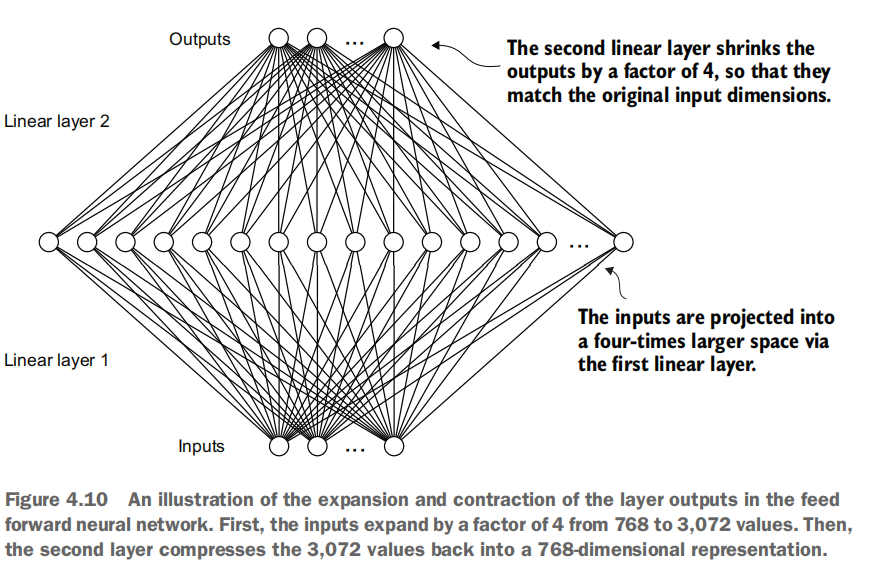

In [16]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# Residual Connections
### (Short-cut connections)

We will first see a vanishing-gradient problem in a model where residual connections are missing

In [19]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
        GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
        GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
        GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
        GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
        GELU())
        ])
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x) 
            if self.use_shortcut and x.shape == layer_output.shape: 
                x = x + layer_output
            else:
                x = layer_output
        return x

In [20]:
layer_sizes = [3, 3, 3, 3, 3, 1] 
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) 
model_without_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=False
)

In [25]:
def print_gradients(model, x):
 output = model(x) 
 target = torch.tensor([[0.]])
 loss = nn.MSELoss()
 loss = loss(output, target) 
 loss.backward()
 for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name} has gradient mean of {param.grad.abs().mean().item()}\n")

In [26]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0006052075768820941

layers.1.0.weight has gradient mean of 0.00036033481592312455

layers.2.0.weight has gradient mean of 0.0021456123795360327

layers.3.0.weight has gradient mean of 0.004196621477603912

layers.4.0.weight has gradient mean of 0.015148940496146679



The output shows, the gradients become smaller
as we progress from the last layer (layers.4) to the first layer (layers.0), which is
a phenomenon called the vanishing gradient problem.

### Let’s now instantiate a model with skip connections and see how it compares:

In [27]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
 layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127

layers.1.0.weight has gradient mean of 0.20694106817245483

layers.2.0.weight has gradient mean of 0.32896995544433594

layers.3.0.weight has gradient mean of 0.2665732502937317

layers.4.0.weight has gradient mean of 1.3258541822433472



The last layer (layers.4) still has a larger gradient than the other layers. However,
the gradient value stabilizes as we progress toward the first layer (layers.0) and
doesn’t shrink to a vanishingly small value.

## Connecting attention and linear layers in a transformer block

## The transformer block component of GPT

In [33]:
from multihead_attention import MultiHeadAttention
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
                                        d_in=cfg["emb_dim"],
                                        d_out=cfg["emb_dim"],
                                        context_length=cfg["context_length"],
                                        num_heads=cfg["n_heads"], 
                                        dropout=cfg["drop_rate"],
                                        qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        shortcut = x # storing the input, to be added in the output
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        
        shortcut = x 
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut 
        return x

Layer normalization (LayerNorm) is applied before each of these two components,
and dropout is applied after them to regularize the model and prevent overfitting. This
is also known as Pre-LayerNorm. 

Older architectures, such as the original transformer
model, applied layer normalization after the self-attention and feed forward networks
instead, known as Post-LayerNorm, which often leads to worse training dynamics.

In [34]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) 
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# Coding the GPT model

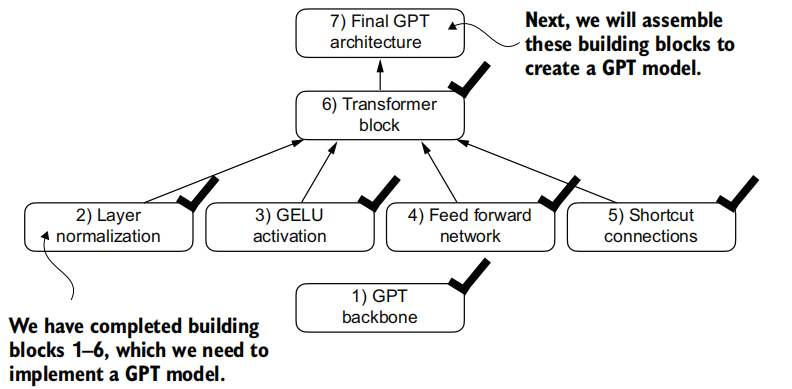

In [35]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [36]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [37]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Why 163M params instead of 124M ?

The reason is a concept called weight tying, which was used in the original GPT-2
architecture. It means that the original GPT-2 architecture reuses the weights from
the token embedding layer in its output layer. 

To understand better, let’s take a look at
the shapes of the token embedding layer and linear output layer that we initialized on
the model via the GPTModel earlier:

In [38]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


The token embedding and output layers are very large due to the number of rows for
the 50,257 in the tokenizer’s vocabulary. Let’s remove the output layer parameter
count from the total GPT-2 model count according to the weight tying:

In [40]:
total_params_gpt2 = (
 total_params - sum(p.numel()
 for p in model.out_head.parameters())
)
print(f"Number of trainable parameters " f"considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [41]:
total_size_bytes = total_params * 4 
total_size_mb = total_size_bytes / (1024 * 1024) 
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


# Generating Text

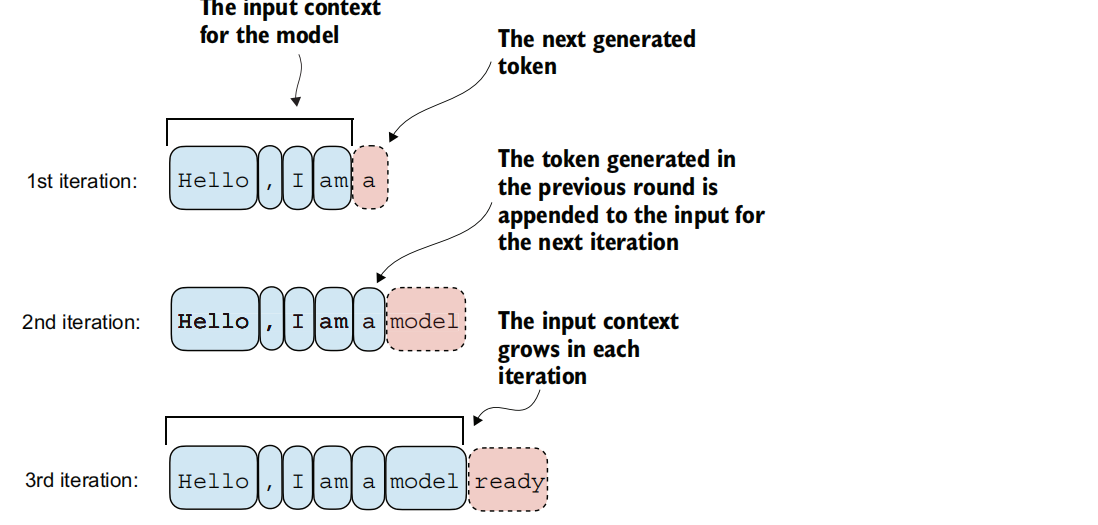

In [82]:
def generate_text_simple(model, idx, max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] 
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]  #Focuses only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1) 
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) 
        idx = torch.cat((idx, idx_next), dim=1)   # Appends sampled index to the running sequence, where idx has shape (batch, n_tokens+1)
        return idx

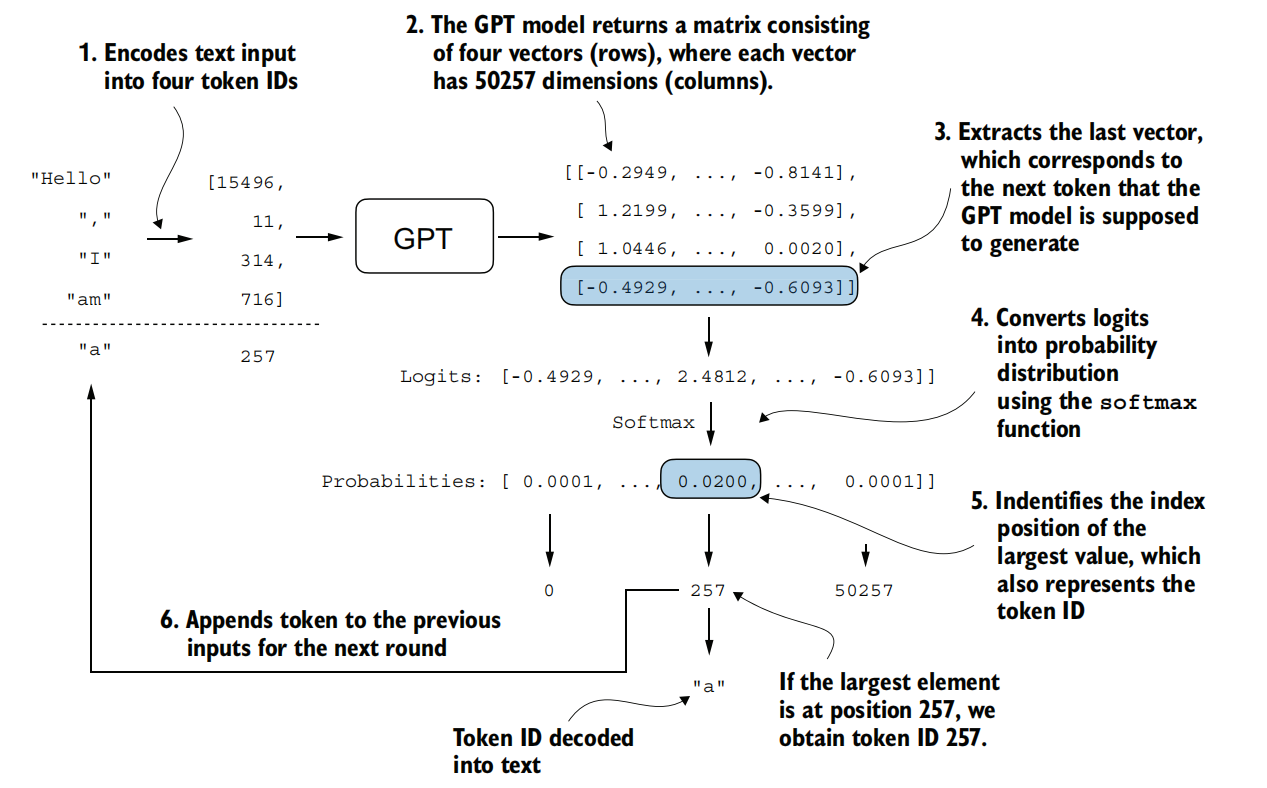

In [83]:
start_context = "My name is "
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #Adds batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [3666, 1438, 318, 220]
encoded_tensor.shape: torch.Size([1, 4])


In [84]:
model.eval() 
out = generate_text_simple(
 model=model,
 idx=encoded_tensor, 
 max_new_tokens=6, 
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[ 3666,  1438,   318,   220, 42473]])
Output length: 5


In [85]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

My name is TRUMP


# End Of Notebook